In [2]:
using CSV, DataFrames
using LinearAlgebra
using PyPlot
using Test
using Printf
using Statistics
using Combinatorics
using Colors

In [3]:
#Have an GUI plot window pop up
pygui(false)

false

In [4]:
#Read in MOFs

_df_henry = CSV.read("../data/expt_henry_coefs.csv")
for (i, xtal) in enumerate(_df_henry[:crystal])
    # Check replace() out for string replacement
    _df_henry[i, :crystal] = split(split(_df_henry[i, :crystal], ".cif")[1], "_")[1]
end
dropmissing!(_df_henry)
global const df_henry = deepcopy(_df_henry)

,crystal,H2O_henry coefficient [mmol/(g-bar)],Temperature [K],CO2_henry coefficient [mmol/(g-bar)],Temperature [K]_1
,String⍰,Float64⍰,Int64⍰,Float64⍰,Int64⍰
1,Al-MIL-53,117.0,298,9.91398,304
2,MIL-101,968.0,298,0.733852,303
3,MIL-101-NH2,4050.0,298,57.3919,293
4,MIL-101-NO2,503.0,298,4.61886,293
5,MIL-125,27500.0,298,2.04678,298
6,MIL-125-NH2,31000.0,298,3.63076,298
7,MIL-68,25.3,298,2.64339,298
8,MIL-68-NH2,117.0,298,4.48421,298
9,SIM-1,133.0,298,9.36078,303


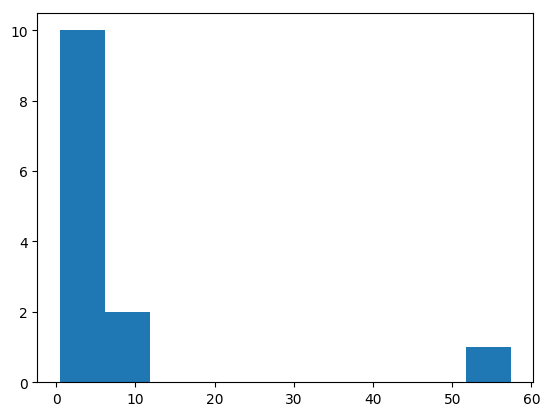

([10.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.471066, 6.16315, 11.8552, 17.5473, 23.2394, 28.9315, 34.6236, 40.3157, 46.0078, 51.6999, 57.3919], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f9e60108518>, PyObject <matplotlib.patches.Rectangle object at 0x7f9e60108320>, PyObject <matplotlib.patches.Rectangle object at 0x7f9e60108860>, PyObject <matplotlib.patches.Rectangle object at 0x7f9e60108ba8>, PyObject <matplotlib.patches.Rectangle object at 0x7f9e60108ef0>, PyObject <matplotlib.patches.Rectangle object at 0x7f9e601152b0>, PyObject <matplotlib.patches.Rectangle object at 0x7f9e60115630>, PyObject <matplotlib.patches.Rectangle object at 0x7f9e601159b0>, PyObject <matplotlib.patches.Rectangle object at 0x7f9e60115d30>, PyObject <matplotlib.patches.Rectangle object at 0x7f9e6011b0f0>])

In [5]:
data = df_henry[Symbol("CO2_henry coefficient [mmol/(g-bar)]")]
plt[:hist](data)

In [6]:
function plot_histogram()
    fig = figure(figsize=(10,8))
    gases = ["CO2", "C2H6", "CH4", "H2S"]
    gas_labels = [L"CO$_2$", L"C$_2$H$_6$", L"CH$_4$", L"H$_2$S"]
    gas_textures = ["+", "O", "/", "*"]
    bin_size = 1.35
    maximum_value = maximum([maximum(df_henry[Symbol(gases[i] * "_henry coefficient [mmol/(g-bar)]")]) for i = 1:length(gases)])
    print(typeof(maximum_value))
    for (i, gas) in enumerate(gases)
        plt[:hist](df_henry[Symbol(gas * "_henry coefficient [mmol/(g-bar)]")], label=gas_labels[i],
            alpha=0.65, bins=range(0, stop=maximum_value + bin_size, step=bin_size), hatch=gas_textures[i])
    end
    legend()
    # grid()
    xlabel("Henry Coeffecient (mmol/(g-bar))")
    ylabel("Number of MOFs")
    title("")
    
end
#plot_histogram()

plot_histogram (generic function with 1 method)

In [7]:
function perform_svd(gas1::AbstractString, gas2::AbstractString)
    #Should we create the program for comparing just two MOFs?
    #Or should it be able to compare 3 as well?

    # MOFs[1] indicates the length of the first column, eg. the number of MOFs being screened
    #initialize Henry's Matrix
    N = size(df_henry)[1]
    sigma = zeros(N, N, 2)

    for i = 1:N
        for j = i+1:N
            H = make_h_matrix(i, j, gas1, gas2)
            F = svd(H)
            sigma[i, j, :] = F.S
        end
    end
    return sigma
end

perform_svd (generic function with 1 method)

In [8]:
function make_h_matrix(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = zeros(2,2)
    H[1, 1] = df_henry[mof1, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")]
    H[1, 2] = df_henry[mof1, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")]
    H[2, 1] = df_henry[mof2, Symbol(gas1 * "_henry coefficient [mmol/(g-bar)]")]
    H[2, 2] = df_henry[mof2, Symbol(gas2 * "_henry coefficient [mmol/(g-bar)]")]
    return H
end

make_h_matrix (generic function with 1 method)

In [9]:
sigma = perform_svd("CO2","H2O")

13×13×2 Array{Float64,3}:
[:, :, 1] =
 0.0  975.047  4052.1    516.472  …    747.931  35200.2  410000.0      
 0.0    0.0    4164.45  1090.89       1217.67   35213.3       4.10001e5
 0.0    0.0       0.0   4081.52       4117.21   35432.2  410020.0      
 0.0    0.0       0.0      0.0         893.714  35203.6       4.1e5    
 0.0    0.0       0.0      0.0       27509.9    44668.7       4.10921e5
 0.0    0.0       0.0      0.0    …  31008.8    46904.6       4.1117e5 
 0.0    0.0       0.0      0.0         739.153  35200.0  410000.0      
 0.0    0.0       0.0      0.0         747.929  35200.2  410000.0      
 0.0    0.0       0.0      0.0         750.6    35200.3  410000.0      
 0.0    0.0       0.0      0.0         740.916  35200.0  410000.0      
 0.0    0.0       0.0      0.0    …      0.0    35207.8       4.10001e5
 0.0    0.0       0.0      0.0           0.0        0.0       4.11508e5
 0.0    0.0       0.0      0.0           0.0        0.0       0.0      

[:, :, 2] =
 0.0  9.75427

In [10]:
function argmin_without_zero(matrix::Array{Float64, 2})
    index = CartesianIndex(1,1)
    lowest = Inf
    for i = 1:size(matrix)[1]
        for j = 1:size(matrix)[2]
            if matrix[i,j] < lowest && !isapprox(matrix[i,j], 0.0)
                lowest = matrix[i,j]
                index = CartesianIndex(i,j)
            end
        end
    end
    return index, lowest
end
    

argmin_without_zero (generic function with 1 method)

In [11]:
idx, lowest = argmin_without_zero(sigma[:,:,1])

(CartesianIndex(7, 10), 62.38070032127974)

In [12]:
function analyze_svd(sigma::Array{Float64, 3})

    #initialize some arrays
    best_indices = argmax(sigma[:, :, 2]) # finds the largest σ₂ value
    #TODO Needs fixing. worst_indices doesn't work
    worst_indices = argmin_without_zero(sigma[:, :, 1])[1] # finds the smallest σ₁ value

    MOF1 = String(df_henry[best_indices[1], :crystal])
    MOF2 = String(df_henry[best_indices[2], :crystal])

    println("The most sensitive pair of MOFs is " * MOF1 * " and " * MOF2)

    MOF3 = String(df_henry[worst_indices[1], :crystal])
    MOF4 = String(df_henry[worst_indices[2], :crystal])

    println("The least sensitive pair of MOFs is " * MOF3 * " and " * MOF4)

    #error analysis?
    #Delta K/H?

#=
    #create circle array
    n = 1000
    #TODO change to range
    x_lin = linspace(-1,1,n)
    y = zeros(2*n)
    x = zeros(2*n)
    for i = 1:n
        y[2 * i] = sqrt(1 - (x_lin[i] ^ 2))
        y[2 * i - 1] = - sqrt(1 - (x_lin[i] ^ 2))
        x[2 * i] = x_lin[i]
        x[2 * i - 1] = x_lin[i]
    end

    xx = x
    yy = y

    pre_plot = plot(x = xx, y = yy, Geom.point, Guide.xlabel("x"), Guide.ylabel("y"))

    #formats the xy coords appropriately
    xy = hcat(x, y)
    xy = transpose(xy)

    #stretches the xy coords by the sigma from the svd
    highest_sigma = sigma[highest_index[1], highest_index[2]]
    sigma = [highest_sigma[1] 0; 0 highest_sigma[2]]
    println(sigma)
    xy_stretched = sigma*xy

    post_plot = plot(x = xy_stretched[1,:], y = xy_stretched[2,:], Geom.point, Guide.xlabel("x"), Guide.ylabel("y"))

    return post_plot
    =#
end

analyze_svd (generic function with 1 method)

In [13]:
function mof2index(mof::AbstractString)
    boolarray = mof .== df_henry[:crystal]
    if sum(boolarray) > 1
        @error "More than one MOF match the given MOF name"
    elseif sum(boolarray) == 0
        @error "No MOF matched the given MOF name"
    end
    return argmax(boolarray)
end

mof2index (generic function with 1 method)

In [14]:
function plot_response(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = make_h_matrix(mof1, mof2, gas1, gas2)
    F = svd(H)
    θ = range(0, stop=2*π, length=500)[1:end-1]
    p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
    n = H * p # required input

    S = perform_svd(gas1, gas2)
    biggest_σ = maximum(S[:, :, 1])

    function plot_vector(x; head_length=0.05, head_width=0.05, color="k", label="", label_dist=0.05)
        x_plot = x - head_length * x / norm(x)
        arrow(0, 0, x_plot[1], x_plot[2], head_width=head_width,
            head_length=head_length, fc=color, ec=color, zorder=1000000)
        x_label = x + x / norm(x) * label_dist
        text(x_label[1], x_label[2], label)
    end

    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=2 * π)

    m = plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt[:cm][:hsv])
    m[:set_array]([]) # trick


    figure(figsize=(11, 5))
    subplot(121, aspect="equal")
    for i = 1:length(θ)-1
        plot(p[1, i:i+1], p[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    xlim([-1.1, 1.1])
    ylim([-1.1, 1.1])
    axis("equal")
    xlabel(@sprintf("\$p_{%s}^*\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}^*\$ (bar)", gas2))
    for k = 1:2
        plot_vector(F.V[:, k], color="k",
            label="\$\\mathbf{v}_$k\$", label_dist=0.1)
    end
    title("Composition Space")
    tight_layout()

    subplot(122, aspect="equal")
    ylim([-biggest_σ, biggest_σ])
    xlim([-biggest_σ, biggest_σ])
    for i = 1:length(θ)-1
        plot(n[1, i:i+1], n[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    for k = 1:2
        plot_vector(F.U[:, k] * F.S[k], head_length=0.005,
            head_width=0.05/3, color="k", label="\$\\sigma_$k\\mathbf{u}_$k\$", label_dist=0.025)
    end
    axis("equal")
    xlabel(@sprintf("\$n_{%i}^*\$ (mmol of total gas)", mof1))
    ylabel(@sprintf("\$n_{%i}^*\$ (mmol of total gas)", mof2))
    title("Response Space")
    tight_layout()
    savefig(@sprintf("composition_response_of_%i_and_%i.png", mof1, mof2), format="png", dpi=300)
end

plot_response(mof1::AbstractString, mof2::AbstractString, gas1::AbstractString, gas2::AbstractString) = plot_response(mof2index(mof1), mof2index(mof2), gas1, gas2)

plot_response (generic function with 2 methods)

In [22]:
function plot_all_responses(gas1::AbstractString, gas2::AbstractString, index_list::Union{Array{Int64, 1}, Missing}=missing; 
                            print_h_matrix::Bool=false, add_legend::Bool=false, color_by_sigma::Int64=2, CN_limit::Float64=100.0)
    
    if color_by_sigma > 2 || color_by_sigma < 1
        error("`color_by_sigma` has to be 1 or 2")
    end
    S = perform_svd(gas1, gas2)
    biggest_σ₂ = maximum(S[:, :, 2])
    
    
    figure(figsize=(11, 5))
    subplot(121, aspect="equal")
    θ = range(0, stop=2*π, length=500)[1:end-1]
    p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
    #rectangle_1x = range(-2, stop=2, length=100)
    #rectangle_
    
    for i = 1:length(θ)-1
        plot(p[1, i:i+1], p[2, i:i+1], lw=2, c="k")
    end
    xlim([-1.1, 1.1])
    ylim([-1.1, 1.1])
    axis("equal")
    xlabel(@sprintf("\$p_{%s}^*\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}^*\$ (bar)", gas2))
    #for k = 1:2
    #    plot_vector(F.V[:, k], color="r",
    #        label="\$\\mathbf{v}_$k\$", label_dist=0.1)
    #end
    title("Composition Space")
    
    if index_list !== missing
        number_of_mofs = length(index_list)
        if number_of_mofs < 2
            @error "Need more than one index to plot the response!"
        end
        pairs = combinations(index_list, 2)
    else
        number_of_mofs = size(df_henry)[1]
        pairs = combinations(1:number_of_mofs, 2)
    end
    
#    cols = distinguishable_colors(size(collect(pairs))[1]+3, [RGB(1,1,1)])[4:end]
    ax = subplot(122)
    #plt[:yscale]("symlog")
    #plt[:xscale]("symlog")
    axis("equal")

    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=biggest_σ₂)

    m = plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt[:cm][:rainbow])
    m[:set_array]([]) # trick

    
    for (k, pair) in enumerate(pairs)
        mof1 = df_henry[pair[1], :crystal]
        mof2 = df_henry[pair[2], :crystal]
        label = @sprintf("%s and %s", mof1, mof2)
        #@printf("Plotting %s and %s\n", mof1, mof2)
        H = make_h_matrix(pair[1], pair[2], gas1, gas2)
        #if k == 1
        #    H = [-10 30; 72 9]
        #end
        if print_h_matrix
            println(pair)
            println(H)
        end
        F = svd(H)
        v1 = F.U[:,1] * F.S[1]
        if abs(v1[1]) > abs(v1[2])
            temp = H[1,:]
            H[1,:] = H[2,:]
            H[2,:] = [temp...]
        end
        CN = F.S[1]/F.S[2]
        if CN > CN_limit
            #@printf("Pair %d - %d has too high of a CN: %.3f. Skipping that pair...\n", pair[1], pair[2], CN)
            continue
        end
        @printf("Condition number for %d - %d: %f\n", pair[1], pair[2], CN)
        θ_response = collect(range(0, stop=2*π, length=250))#[1:end - 1]
        θ_response[1] = deepcopy(θ_response[end])
        p_response = transpose(hcat(cos.(θ_response), sin.(θ_response))) # set pt change
        n = H * p_response # required input
        #for i = 1:length(θ_response) - 1
        #    plot(n[1, i:i+1], n[2, i:i+1], alpha=0.75, lw=3, c="#" * string(hex(cols[k])))#, label = label)
        #end
        plot(n[1,:], n[2, :], label=@sprintf("%s - %s",df_henry[pair[1], :crystal], df_henry[pair[2], :crystal]), 
            c=m[:to_rgba](F.S[color_by_sigma]))
    end
    if add_legend
        legend()
    end
    title(@sprintf("Response Space"))
    xlabel(@sprintf("\$n_1\$ (mmol/g)"))
    ylabel(@sprintf("\$n_2\$ (mmol/g)"))
    cbar = colorbar(m)
    cbar[:ax][:set_ylabel](@sprintf("\$ \\sigma_%d \$", color_by_sigma))
end

plot_all_responses(gas1::AbstractString, gas2::AbstractString, mof_list::Array{String, 1}) = plot_all_responses(gas1, gas2, mof2index.(mof_list))

plot_all_responses (generic function with 3 methods)

Condition number for 1 - 8: 43.259013
Condition number for 

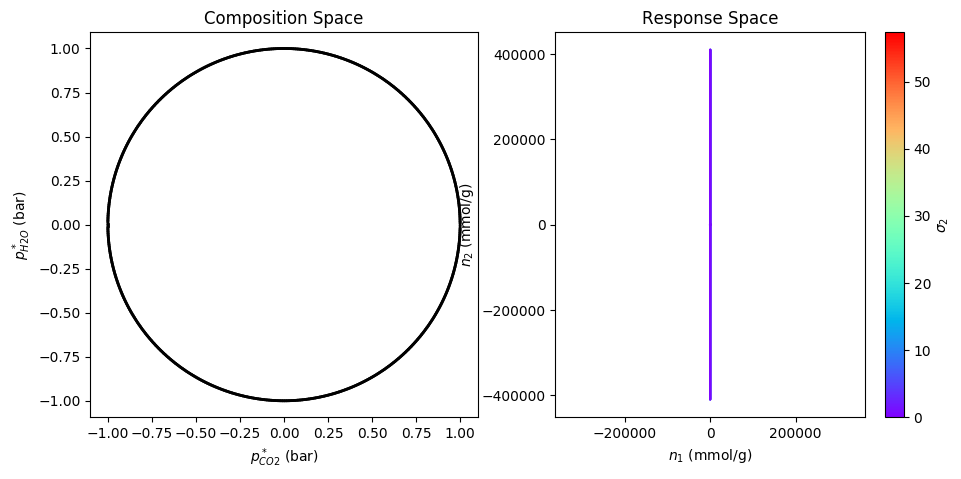

1 - 10: 33.376143
Condition number for 1 - 13: 41359.321729
Condition number for 8 - 10: 84.574647
Condition number for 8 - 13: 91449.384605
Condition number for 10 - 13: 871135.093451


PyObject Text(936.781,0.5,'$ \\sigma_2 $')

In [23]:
plot_all_responses("CO2", "H2O", [1,8,10,13], CN_limit=Inf)

In [24]:
H = make_h_matrix(3,4,"CO2", "H2O_TIP4PEw")
figure(figsize=(11, 5))
subplot(121, aspect="equal")
θ = range(0, stop=2*π, length=500)[1:end-1]
p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
for i = 1:length(θ)-1
    plot(p[1, i:i+1], p[2, i:i+1], lw=2, c="k")
end
xlim([-1.1, 1.1])
ylim([-1.1, 1.1])
axis("equal")

ax = subplot(122)
axis("equal")
S = perform_svd("CO2", "H2O_TIP4PEw")
biggest_σ₂ = maximum(S[:, :, 2])

cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=biggest_σ₂)

m = plt[:cm][:ScalarMappable](norm=cnorm, cmap=plt[:cm][:rainbow])
m[:set_array]([]) # trick

θ_response = collect(range(0, stop=2*π, length=250))#[1:end - 1]
θ_response[1] = deepcopy(θ_response[end])
p_response = transpose(hcat(cos.(θ_response), sin.(θ_response))) # set pt change
n = H * p_response # required input
#for i = 1:length(θ_response) - 1
#    plot(n[1, i:i+1], n[2, i:i+1], alpha=0.75, lw=3, c="#" * string(hex(cols[k])))#, label = label)
#end
plot(n[1,:], n[2, :])
S[3,4,:]

KeyError: KeyError: key Symbol("H2O_TIP4PEw_henry coefficient [mmol/(g-bar)]") not found

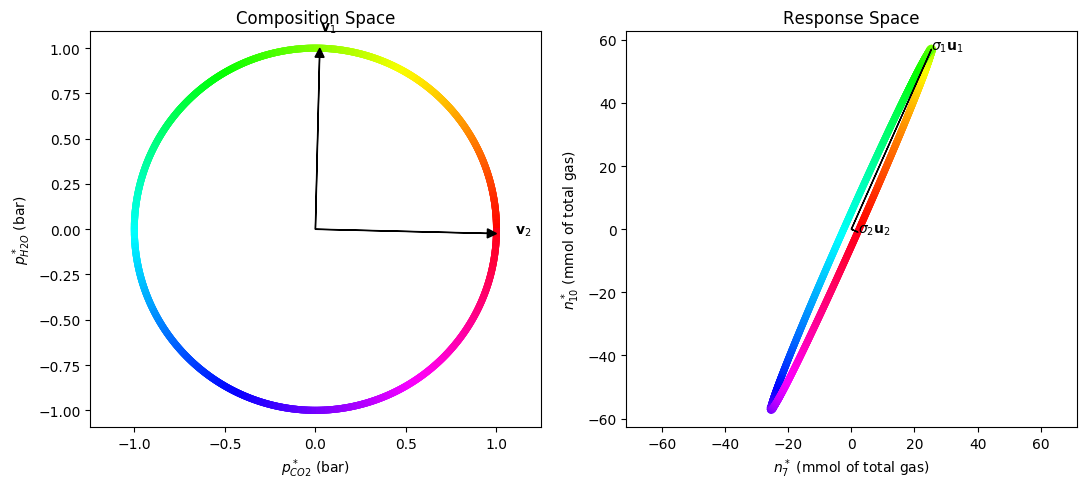

In [25]:
plot_response(7, 10, "CO2", "H2O")

In [26]:
sigma = perform_svd("H2O", "CO2")
analyze_svd(sigma)

The most sensitive pair of MOFs is MIL-101-NH2 and UiO-66-NH2
The least sensitive pair of MOFs is MIL-68 and ZIF-8


In [27]:
#@testset "Sensor Tests" begin
#    H = make_h_matrix(3, 5, "CO2", "C2H6")
#    G = [(8.91e-5) (4.84e-5); (1.87e-5) (4.68e-5)] .- [5.84e-6; 9.56e-6]
#    @test isapprox(H, G)
#end

In [28]:
@testset "MOF to index test" begin
    @test isapprox(mof2index("MIL-101"), 2)
end

Test Summary:     | Pass  Total
MOF to index test |    1      1


Test.DefaultTestSet("MOF to index test", Any[], 1, false)

# Lets Try another Idea!

In [118]:
function plot_rectangle(gas1::AbstractString, gas2::AbstractString, l_gas1::Float64, l_gas2::Float64, index_list::Union{Array{Int64, 1}, Missing}=missing)
    wid = range(0, stop=l_gas1, length=20)
    len = range(0, stop=l_gas2, length=20)
    grid_a = [i for i in wid, j in len]
    grid_b = [j for i in wid, j in len]
    p = transpose([grid_a[:] grid_b[:]])

    figure(figsize=(11, 5))
    subplot(121)
    
    scatter(p[1,:], p[2,:], s=3)
    #axis("equal")
    xlim([-0.1*maximum(p[1,:]), maximum(p[1,:]*1.1)])
    ylim([-0.1*maximum(p[2,:]), maximum(p[2,:]*1.1)])
    title("Composition Space")
    xlabel(@sprintf("\$p_{%s}\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}\$ (bar)", gas2))

    ax = subplot(122)
    #axis("equal")
    
    if index_list !== missing
        println(typeof(index_list))
        println(index_list)
        println(length(index_list))
        number_of_mofs = length(index_list)
        if number_of_mofs < 2
            @error "Need more than one index to plot the response!"
        end
        pairs = combinations(index_list, 2)
    else
        number_of_mofs = size(df_henry)[1]
        pairs = combinations(1:number_of_mofs, 2)
    end

    for (k, pair) in enumerate(pairs)
        mof1 = df_henry[pair[1], :crystal]
        mof2 = df_henry[pair[2], :crystal]
        label = @sprintf("%s and %s", mof1, mof2)
        H = make_h_matrix(pair[1], pair[2], gas1, gas2)
        F = svd(H)
        n = H * p
        scatter(n[1,:], n[2,:], s=3)
        xlim([-0.1*maximum(n[1,:]), maximum(n[1,:]*1.1)])
        ylim([-0.1*maximum(n[2,:]), maximum(n[2,:]*1.1)])

    end
end
    
plot_rectangle(gas1::AbstractString, gas2::AbstractString, l_gas1::Float64, l_gas2::Float64, mof_list::Array{String, 1}) = plot_rectangle(gas1, gas2, l_gas1, l_gas2, mof2index.(mof_list))

plot_rectangle (generic function with 5 methods)

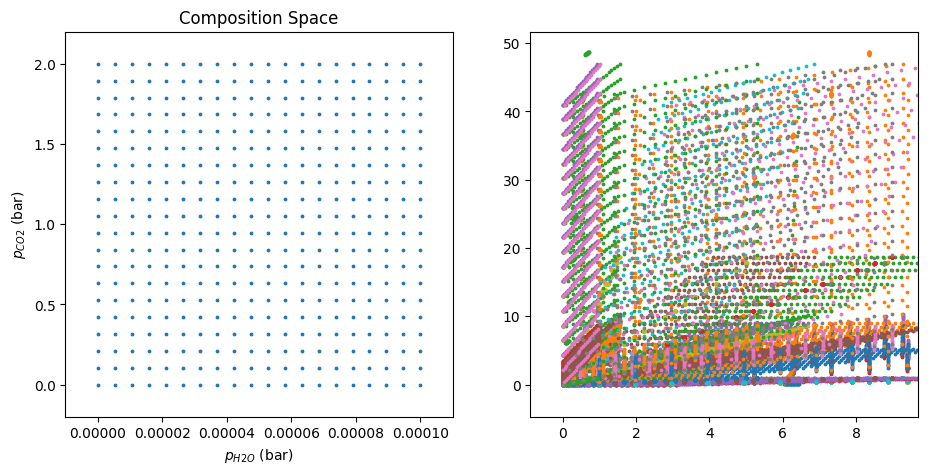

In [119]:
plot_rectangle("H2O", "CO2", 0.0001, 2.0)

In [145]:
function plot_rectangle2(gas1::AbstractString, gas2::AbstractString, l_gas1::Float64, l_gas2::Float64, index_list::Union{Array{Int64, 1}, Missing}=missing)
    p = [0.0 0.0 l_gas1 l_gas1;
         0.0 l_gas2 l_gas2 0.0]

    figure(figsize=(11, 5))
    subplot(121)
    
    for i = 1:size(p)[2]-1
        plot(p[1, i:i+1], p[2, i:i+1], lw=2, c="k")
    end
    plot([p[1, end], p[1, 1]], [p[2, end], p[2, 1]], lw=2, c="k")
    #axis("equal")
    #xlim([-0.1*maximum(p[1,:]), maximum(p[1,:]*1.1)])
    #ylim([-0.1*maximum(p[2,:]), maximum(p[2,:]*1.1)])
    title("Composition Space")
    xlabel(@sprintf("\$p_{%s}\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}\$ (bar)", gas2))

    ax = subplot(122)
    #axis("equal")
    
    if index_list !== missing
        number_of_mofs = length(index_list)
        if number_of_mofs < 2
            @error "Need more than one index to plot the response!"
        end
        pairs = combinations(index_list, 2)
    else
        number_of_mofs = size(df_henry)[1]
        pairs = combinations(1:number_of_mofs, 2)
    end

    for (k, pair) in enumerate(pairs)
        mof1 = df_henry[pair[1], :crystal]
        mof2 = df_henry[pair[2], :crystal]
        label = @sprintf("%s and %s", mof1, mof2)
        H = make_h_matrix(pair[1], pair[2], gas1, gas2)
        F = svd(H)
        n = H * p
        for i = 1:size(n)[2]-1
            plot(n[1, i:i+1], n[2, i:i+1], lw=2, c="b")
        end
        plot([n[1, end], n[1, 1]], [n[2, end], n[2, 1]], lw=2, c="b")
        #xlim([-0.1*maximum(n[1,:]), maximum(n[1,:]*1.1)])
        #ylim([-0.1*maximum(n[2,:]), maximum(n[2,:]*1.1)])

    end
end
    
plot_rectangle2(gas1::AbstractString, gas2::AbstractString, l_gas1::Float64, l_gas2::Float64, mof_list::Array{String, 1}) = plot_rectangle2(gas1, gas2, l_gas1, l_gas2, mof2index.(mof_list))

plot_rectangle2 (generic function with 3 methods)

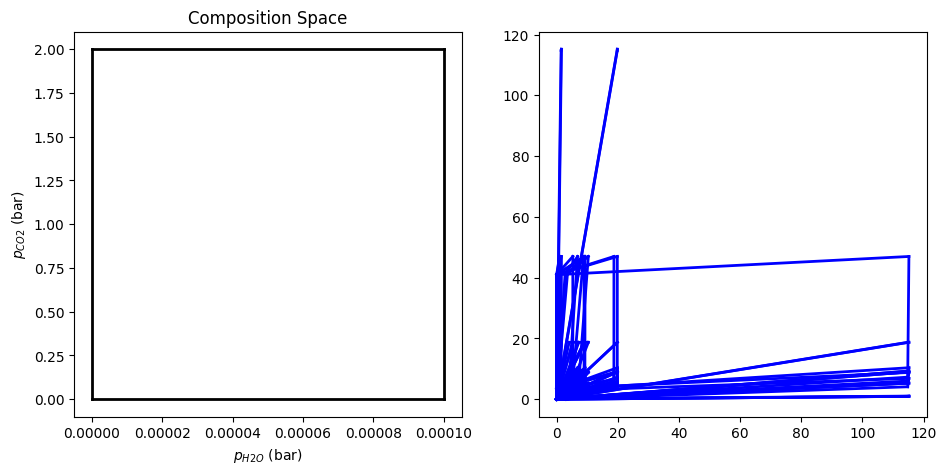

In [147]:
plot_rectangle2("H2O", "CO2", 0.0001, 2.0)